# Mosi
## Goal
- Learn to prepare text features using Transformer encoders
- Learn to align timestep of features from different modalities
- Implement and compare different strategies of multi-modal fusion
  - Early Fusion
  - Late Fusion

## Env Setup
We are going to work on the mosi dataset. First, let's prepare our env

In [ ]:
!pip install -U memory_profiler

In [ ]:
!git clone -b 535 https://github.com/Ja1Zhou/MultiBench.git
%cd MultiBench

Cloning into 'MultiBench'...
remote: Enumerating objects: 6948, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 6948 (delta 73), reused 123 (delta 61), pack-reused 6789
Receiving objects: 100% (6948/6948), 51.08 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (4259/4259), done.
/content/MultiBench


In [ ]:
!ls

coverage.xml	 examples     objective_functions   robustness		 tutorial.md
datasets	 fusions      pretrained	    special		 unimodals
deprecated	 images       private_test_scripts  sphinx		 utils
environment.yml  __init__.py  README.md		    tests
eval_scripts	 LICENSE      requirements.txt	    training_structures


## Dataset Preparation
Now, let's load the data and see what we have

In [ ]:
# !pip install gdown
!gdown https://drive.google.com/uc?id=12HbavGOtoVCqicvSYWl3zImli5Jz0Nou
!gdown https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU
!mkdir data
!mv mosi_raw.pkl data
!mv mosi.pkl data

Downloading...
From: https://drive.google.com/uc?id=12HbavGOtoVCqicvSYWl3zImli5Jz0Nou
To: /content/MultiBench/mosi.pkl
100% 14.2M/14.2M [00:00<00:00, 42.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU
From (redirected): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU&confirm=t&uuid=47bd9252-dfb1-413e-84a3-0d7d689c7594
To: /content/MultiBench/mosi_raw.pkl
100% 357M/357M [00:01<00:00, 186MB/s]


In [ ]:
import pandas as pd
import pickle as pkl
import numpy as np
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import torch
with open("./data/mosi.pkl", 'rb') as f:
    mosi = pkl.load(f)
mosi.keys()

dict_keys(['train', 'dev', 'test'])

## Prepare Our Tokenizer

In [ ]:
%env TOKENIZERS_PARALLELISM='true';

env: TOKENIZERS_PARALLELISM='true';


In [ ]:
from transformers import AutoTokenizer
from transformers.modeling_outputs import BaseModelOutput
model_name_or_path="distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

## Data Exploration
Let's understand the structure of our dataset

In [ ]:
mosi_train = mosi['train']
len(mosi_train[0])

3

In [ ]:
features, labels, _ = zip(*mosi_train)
len(features), len(labels)

(1281, 1281)

In [ ]:
words, visual, acoustic = zip(*features)
len(words), len(visual), len(acoustic)

(1281, 1281, 1281)

In [ ]:
type(words[0]), type(visual[0]), type(acoustic[0])

(list, numpy.ndarray, numpy.ndarray)

`Important`! As you can see here. The number of words aligns with the number of visual and acoustic features.

In [ ]:
words[0], visual[0].shape, acoustic[0].shape

(['anyhow', 'it', 'was', 'really', 'good'], (5, 47), (5, 74))

In [ ]:
words = pd.Series(list(words))
words

0                         [anyhow, it, was, really, good]
1       [they, didnt, really, do, a, whole, bunch, of,...
2            [i, mean, they, did, a, little, bit, of, it]
3                             [but, not, a, whole, bunch]
4                         [and, they, shouldve, i, guess]
                              ...                        
1276       [uh, i, rated, it, four, out, of, five, stars]
1277    [um, the, one, thing, i, didnt, like, about, t...
1278                   [but, that, didnt, really, matter]
1279           [um, everything, else, held, up, its, own]
1280    [um, definitely, check, out, this, movie, rang...
Length: 1281, dtype: object

In [ ]:
visual = [torch.tensor(v) for v in visual]
# pad visual features to the same length
visual = torch.nn.utils.rnn.pad_sequence(visual, batch_first=True)
visual.shape

torch.Size([1281, 104, 47])

In [ ]:
acoustic = [torch.tensor(a) for a in acoustic]
# pad acoustic features to the same length
acoustic = torch.nn.utils.rnn.pad_sequence(acoustic, batch_first=True)
acoustic.shape

torch.Size([1281, 104, 74])

## Feature Preparation
It is clear that our visual and acoustic features are pre-extracted. We need to work on the text features. We will use the pre-trained BERT model to extract the features from the text.

First, let's checkout the necessary apis

In [ ]:
# tokenized = tokenizer(words, is_split_into_words=True, padding='max_length', truncation=True, return_tensors='pt', max_length=10)
tokenized = tokenizer(words.tolist(), is_split_into_words=True, )
input_ids = tokenized['input_ids']
len(input_ids)

1281

In [ ]:
word_indices = [tokenized.word_ids(batch_index=i) for i in range(len(input_ids))]
len(word_indices)

1281

Pay close attention to the `word_indices` here. Because of the tokenization process, words could end up being split into multiple tokens

In [ ]:
print(tokenizer.convert_ids_to_tokens(input_ids[0]), '\n', word_indices[0])

['[CLS]', 'any', '##how', 'it', 'was', 'really', 'good', '[SEP]'] 
 [None, 0, 0, 1, 2, 3, 4, None]


In [ ]:
input_ids_len = [len(i) for i in input_ids]
input_ids_len[:5]

[8, 22, 11, 7, 8]

To work with text data, we would need to determine a maximum length for the text. Here is an analysis of the length of the text.

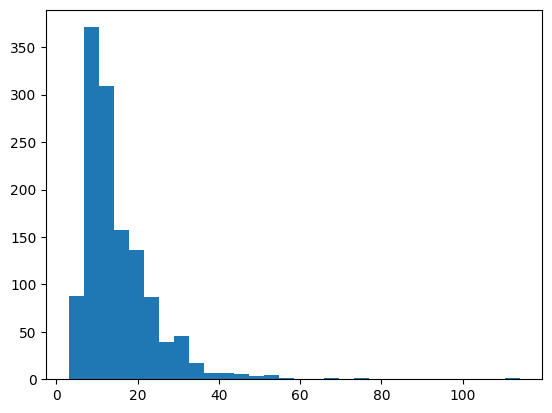

In [ ]:
# matplotlib visualize input_ids_len as histogram
import matplotlib.pyplot as plt
plt.hist(input_ids_len, bins=30)
plt.show()

We would use 30 as our maximum length for the text.

In [ ]:
max_text_seq_length=30
tokenized = tokenizer(words.tolist(), is_split_into_words=True, padding='max_length', truncation=True, return_tensors='pt', max_length=max_text_seq_length)
input_ids = tokenized['input_ids']
word_indices = [tokenized.word_ids(batch_index=i) for i in range(len(input_ids))]
# input_ids = pd.Series(input_ids)
attention_masks = tokenized['attention_mask']
# attention_masks = pd.Series(attention_masks)
word_indices = torch.tensor([[-1 if i is None else i for i in batch] for batch in word_indices])
# word_indices = pd.Series(word_indices)
input_ids.shape, word_indices.shape, attention_masks.shape

(torch.Size([1281, 30]), torch.Size([1281, 30]), torch.Size([1281, 30]))

We would be consistent and use the same maximum length for the text, visual and acoustic features.

In [ ]:
visual = visual[:, :max_text_seq_length, :]
acoustic = acoustic[:, :max_text_seq_length, :]
visual.shape, acoustic.shape

(torch.Size([1281, 30, 47]), torch.Size([1281, 30, 74]))

In [ ]:
word_indices[0], input_ids[0], attention_masks[0]

(tensor([-1,  0,  0,  1,  2,  3,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 tensor([  101,  2151, 14406,  2009,  2001,  2428,  2204,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]))

## Text Model Instantiation

In [ ]:
from transformers import AutoModel
model = AutoModel.from_pretrained(model_name_or_path)
model

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda')

## `TODO`: Forward Text through BERT to obtain Embeddings
Our scheme for obtaining text features is as follows.

- We are going to forward tokenized text through BERT and obtain last hidden states.
- For words that are split into multiple tokens, we would use the average of the hidden states as the representation for the word.
- We need to make sure that the number of text features for each sample aligns with visual and acoustic features. This is because our dataset aligns these modalities.
- For padding features, we would use the zero vector as the representation.

In [ ]:
batch_size = 32
word_embedding = torch.zeros((input_ids.size(0), max_text_seq_length, model.config.hidden_size)).to(device)

In [ ]:
# (1, seq_len)
seq_pos_tensor = torch.arange(max_text_seq_length, dtype=torch.long).to(device)[None,:, None]
seq_pos_tensor = seq_pos_tensor.expand(-1, -1, max_text_seq_length)
seq_pos_tensor.shape
for idx in range(0, len(input_ids), batch_size):
    # (bs, seq_len)
    batch_input_ids = input_ids[idx:idx+batch_size].to(device)
    batch_attention_mask = attention_masks[idx:idx+batch_size].to(device)
    batch_word_indices = word_indices[idx:idx + batch_size].to(device)

    with torch.no_grad():
        model_outputs:BaseModelOutput = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
    # (bs, seq_len, hidden_size)
    last_hidden_state:torch.Tensor = model_outputs.last_hidden_state

    # (bs, seq_len, seq_len)
    # dim 2: token to word
    batch_word_indices = batch_word_indices[:, None, :].expand(-1, max_text_seq_length, -1)
    # dim 1: pos
    batch_pos_tensor = seq_pos_tensor.expand(batch_input_ids.size(0), -1, -1)
    token_to_word = batch_word_indices == batch_pos_tensor
    # (bs, pos, token_to_word, hidden_size)
    batch_word_embedding = torch.sum(last_hidden_state[:, None, :, :] * token_to_word[:, :, :, None].float(), dim=2) / token_to_word.float().sum(dim=2)[:, :, None].clamp(min=1.0)
    word_embedding[idx:idx+batch_size] = batch_word_embedding

## Baseline
Now that we have our BERT features for text, let's check out the performance of a baseline model

In [ ]:
# Import the associated dataloader for affect datasets, which MOSI is a part of.
from datasets.affect.get_data import get_dataloader

# Create the training, validation, and test-set dataloaders.
traindata, validdata, testdata = get_dataloader(
    './data/mosi_raw.pkl', robust_test=False, max_pad=True, data_type='mosi', max_seq_len=max_text_seq_length)

Let's checkout the baseline features

In [ ]:
with open("./data/mosi_raw.pkl", 'rb') as f:
    mosi_raw = pkl.load(f)
mosi_raw.keys()

dict_keys(['train', 'valid', 'test'])

In [ ]:
mosi_raw['train'].keys()

dict_keys(['vision', 'audio', 'text', 'labels', 'id'])

We can see that the baseline features has the following dims
- Visual: 35
- Acoustic: 74
- Text: 300

In [ ]:
for i in traindata:
  break
[x.shape for x in i]

[torch.Size([32, 30, 35]),
 torch.Size([32, 30, 74]),
 torch.Size([32, 30, 300]),
 torch.Size([32, 1])]

## Baseline Model
- For modality encoders, we are going to use `Identity`, where there is no learning.
- For modality fusion, we are going to use early fusion with simple concatenation.
- For our classifier, we are going to use a GRU with MLP.

**Note:** The fusion is early because our models directly learn upon the concatenated features. There are no unimodal encoders for learning.

In [ ]:
# Here, we'll import several common modules should you want to mess with this more.
from unimodals.common_models import GRU, MLP, Sequential, Identity

# As this example is meant to be simple and easy to train, we'll pass in identity
# functions for each of the modalities in MOSI:
# encoders = [Identity().cuda(), Identity().cuda(), Identity().cuda()]
encoders = [Identity(), Identity(), Identity()]
encoders = [x.to(device) for x in encoders]
encoders

[Identity(), Identity(), Identity()]

In [ ]:
# Import a fusion paradigm, in this case early concatenation.
from fusions.common_fusions import ConcatEarly  # noqa

# Initialize the fusion module
# fusion = ConcatEarly().cuda()
fusion = ConcatEarly()
fusion = fusion.to(device)
fusion

ConcatEarly()

Hold-on! What is the input dim of `GRU` here?

In [ ]:
head = Sequential(GRU(409, 512, dropout=True, has_padding=False,
                  batch_first=True, last_only=True), MLP(512, 512, 1))
head = head.to(device)
head

Sequential(
  (0): GRU(
    (gru): GRU(409, 512, batch_first=True)
    (dropout_layer): Dropout(p=0.1, inplace=False)
  )
  (1): MLP(
    (fc): Linear(in_features=512, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1, bias=True)
    (dropout_layer): Dropout(p=0.1, inplace=False)
    (lklu): LeakyReLU(negative_slope=0.2)
  )
)

## Train!

In [ ]:
# Standard supervised learning training loop
from training_structures.Supervised_Learning import train, test

# For more information regarding parameters for any system, feel free to check out the documentation
# at multibench.readthedocs.io!
train(encoders, fusion, head, traindata, validdata, 30, task="regression", optimtype=torch.optim.AdamW,
      is_packed=False, lr=1e-3, save='mosi_ef_r0.pt', weight_decay=0.01, objective=torch.nn.L1Loss())

print("Testing:")
my_model = torch.load('mosi_ef_r0.pt').cuda()
test(my_model, testdata, 'affect', is_packed=False,
     criterion=torch.nn.L1Loss(), task="posneg-classification", no_robust=True)

Epoch 0 train loss: tensor(1.3237, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 0 valid loss: 1.3755911588668823
Saving Best
Epoch 1 train loss: tensor(1.3213, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 1 valid loss: 1.383088231086731
Epoch 2 train loss: tensor(1.3184, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2 valid loss: 1.3878344297409058
Epoch 3 train loss: tensor(1.2976, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3 valid loss: 1.3967794179916382
Epoch 4 train loss: tensor(1.2962, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4 valid loss: 1.4040629863739014
Epoch 5 train loss: tensor(1.2815, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 5 valid loss: 1.37238347530365
Saving Best
Epoch 6 train loss: tensor(1.2678, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 6 valid loss: 1.4044997692108154
Epoch 7 train loss: tensor(1.1948, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 7 valid loss: 1.4974186420440674
Epoch 8 train loss: tensor(1.1796, device='cuda:0', grad_fn

## Using Our Text Features!

In [ ]:
with open("./data/mosi.pkl", 'rb') as f:
    mosi = pkl.load(f)

## `TODO`: Let's wrap out feature preparation into a function

In [ ]:
def get_text_visual_audio(split:str='train', max_text_seq_length:int=30, batch_size:int=32):
    '''
    This function is used to get the text, visual, and acoustic features from the MOSI dataset.
    Args:
    split: str: The split to use. One of 'train', 'dev', or 'test'.
    max_text_seq_length: int: The maximum sequence length for the text features.
    batch_size: int: The batch size to use for inference.
    '''
    mosi_split = mosi[split]
    features, labels, _ = zip(*mosi_split)
    words, visual, acoustic = zip(*features)

    # remember to pad our features
    visual = [torch.tensor(v) for v in visual]
    visual = torch.nn.utils.rnn.pad_sequence(visual, batch_first=True)
    acoustic = [torch.tensor(a) for a in acoustic]
    acoustic = torch.nn.utils.rnn.pad_sequence(acoustic, batch_first=True)

    # our text features
    tokenized = tokenizer(words, is_split_into_words=True, padding='max_length', truncation=True, return_tensors='pt', max_length=max_text_seq_length)
    input_ids = tokenized['input_ids']
    word_indices = [tokenized.word_ids(batch_index=i) for i in range(len(input_ids))]
    attention_masks = tokenized['attention_mask']
    word_indices = torch.tensor([[-1 if i is None else i for i in batch] for batch in word_indices])

    # truncate our visual and acoustic features
    visual = visual[:, :max_text_seq_length, :]
    acoustic = acoustic[:, :max_text_seq_length, :]

    # adapt your previously implemented function here
    seq_pos_tensor = torch.arange(max_text_seq_length, dtype=torch.long)[None,:, None]
    seq_pos_tensor = seq_pos_tensor.expand(-1, -1, max_text_seq_length).to(device)

    word_embedding = torch.zeros((input_ids.size(0), max_text_seq_length, model.config.hidden_size)).to(device)

    for idx in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[idx:idx+batch_size].to(device)
        batch_attention_mask = attention_masks[idx:idx+batch_size].to(device)
        batch_word_indices = word_indices[idx:idx + batch_size].to(device)

        with torch.no_grad():
            model_outputs:BaseModelOutput = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        last_hidden_state:torch.Tensor = model_outputs.last_hidden_state

        batch_word_indices = batch_word_indices[:, None, :].expand(-1, max_text_seq_length, -1)
        batch_pos_tensor = seq_pos_tensor.expand(batch_input_ids.size(0), -1, -1)
        token_to_word = batch_word_indices == batch_pos_tensor
        batch_word_embedding = torch.sum(last_hidden_state[:, None, :, :] * token_to_word[:, :, :, None].float(), dim=2) / token_to_word.float().sum(dim=2)[:, :, None].clamp(min=1.0)
        word_embedding[idx:idx+batch_size] = batch_word_embedding
    labels = torch.concat([torch.tensor(l) for l in labels])[:,None,:]

    return word_embedding.cpu().numpy(), visual.numpy(), acoustic.numpy(), labels.numpy()

In [ ]:
mosi_raw['train']['text'], mosi_raw['train']['vision'], mosi_raw['train']['audio'], mosi_raw['train']['labels'] = get_text_visual_audio('train')
mosi_raw['valid']['text'], mosi_raw['valid']['vision'], mosi_raw['valid']['audio'], mosi_raw['valid']['labels'] = get_text_visual_audio('dev')
mosi_raw['test']['text'], mosi_raw['test']['vision'], mosi_raw['test']['audio'], mosi_raw['test']['labels'] = get_text_visual_audio('test')

## DataLoaders
We are going to leverage a custom DataLoader generator function that is similar to the one we used in the baseline model.

In [ ]:
from datasets.affect.get_data import wrap_dataloader
traindata, validdata, testdata = wrap_dataloader(
    mosi_raw, robust_test=False, max_pad=True, data_type='mosi', max_seq_len=max_text_seq_length)

In [ ]:
for i in traindata:
  break
[x.shape for x in i]

[torch.Size([32, 30, 47]),
 torch.Size([32, 30, 74]),
 torch.Size([32, 30, 768]),
 torch.Size([32, 1])]

## How much better are our text features?
We are going to go with the same early fusion that we used in the baseline model.

In [ ]:
# Here, we'll import several common modules should you want to mess with this more.
from unimodals.common_models import GRU, MLP, Sequential, Identity

# As this example is meant to be simple and easy to train, we'll pass in identity
# functions for each of the modalities in MOSI:
# encoders = [Identity().cuda(), Identity().cuda(), Identity().cuda()]
encoders = [Identity(), Identity(), Identity()]
encoders = [x.to(device) for x in encoders]
encoders

[Identity(), Identity(), Identity()]

In [ ]:
# Import a fusion paradigm, in this case early concatenation.
from fusions.common_fusions import ConcatEarly  # noqa

# Initialize the fusion module
# fusion = ConcatEarly().cuda()
fusion = ConcatEarly()
fusion = fusion.to(device)
fusion

ConcatEarly()

In [ ]:
head = Sequential(GRU(47+74+768, 512, dropout=True, has_padding=False,
                  batch_first=True, last_only=True), MLP(512, 512, 1))
head = head.to(device)
head

Sequential(
  (0): GRU(
    (gru): GRU(889, 512, batch_first=True)
    (dropout_layer): Dropout(p=0.1, inplace=False)
  )
  (1): MLP(
    (fc): Linear(in_features=512, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1, bias=True)
    (dropout_layer): Dropout(p=0.1, inplace=False)
    (lklu): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
# Standard supervised learning training loop
from training_structures.Supervised_Learning import train, test

# For more information regarding parameters for any system, feel free to check out the documentation
# at multibench.readthedocs.io!
train(encoders, fusion, head, traindata, validdata, 30, task="regression", optimtype=torch.optim.AdamW,
      is_packed=False, lr=1e-3, save='mosi_ef_bert.pt', weight_decay=0.01, objective=torch.nn.L1Loss())

print("Testing:")
bert_model = torch.load('mosi_ef_bert.pt').cuda()
test(bert_model, testdata, 'affect', is_packed=False,
     criterion=torch.nn.L1Loss(), task="posneg-classification", no_robust=True)

Epoch 0 train loss: tensor(1.3118, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 0 valid loss: 1.404518961906433
Saving Best
Epoch 1 train loss: tensor(1.1790, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 1 valid loss: 1.1557366847991943
Saving Best
Epoch 2 train loss: tensor(0.9772, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2 valid loss: 1.1169354915618896
Saving Best
Epoch 3 train loss: tensor(0.9201, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3 valid loss: 1.1244415044784546
Epoch 4 train loss: tensor(0.8418, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4 valid loss: 0.9867541790008545
Saving Best
Epoch 5 train loss: tensor(0.6911, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 5 valid loss: 1.0008740425109863
Epoch 6 train loss: tensor(0.6661, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 6 valid loss: 0.9939117431640625
Epoch 7 train loss: tensor(0.5781, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 7 valid loss: 1.1515922546386719
Epoch 8 train loss: tensor(0.5679

## That is a nearly 10 point increase!
## Now let's move on to other fusion techniques that we could try out
You are also free to define your own encoders other than GRU

In [ ]:
# Here, we'll import several common modules should you want to mess with this more.
from unimodals.common_models import GRU, MLP, Sequential, Identity, GRUWithLinear

# As this example is meant to be simple and easy to train, we'll pass in identity
# functions for each of the modalities in MOSI:
# encoders = [Identity().cuda(), Identity().cuda(), Identity().cuda()]
encoders = [
    GRU(47, 9, dropout=True, has_padding=False,
                  batch_first=True, last_only=True),
    GRU(74, 9, dropout=True, has_padding=False,
                  batch_first=True, last_only=True),
    GRU(768, 99, dropout=True, has_padding=False,
                  batch_first=True, last_only=True),
]
encoders = [x.to(device) for x in encoders]
encoders

[GRU(
   (gru): GRU(47, 9, batch_first=True)
   (dropout_layer): Dropout(p=0.1, inplace=False)
 ),
 GRU(
   (gru): GRU(74, 9, batch_first=True)
   (dropout_layer): Dropout(p=0.1, inplace=False)
 ),
 GRU(
   (gru): GRU(768, 99, batch_first=True)
   (dropout_layer): Dropout(p=0.1, inplace=False)
 )]

## `TODO`: Create a model with `late fusion` && Implement a fusion other than `Concat`

In [ ]:
# Import a fusion paradigm, in this case early concatenation.
from fusions.common_fusions import TensorFusion  # noqa

# Initialize the fusion module
# fusion = ConcatEarly().cuda()
fusion = TensorFusion()
fusion = fusion.to(device)
fusion

TensorFusion()

In [ ]:
head = MLP(100*10*10, 128, 1)
head = head.to(device)
head

MLP(
  (fc): Linear(in_features=10000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (lklu): LeakyReLU(negative_slope=0.2)
)

In [ ]:
# Standard supervised learning training loop
from training_structures.Supervised_Learning import train, test

# For more information regarding parameters for any system, feel free to check out the documentation
# at multibench.readthedocs.io!
train(encoders, fusion, head, traindata, validdata, 30, task="regression", optimtype=torch.optim.AdamW,
      is_packed=False, lr=1e-3, save='mosi_tf_bert.pt', weight_decay=0.01, objective=torch.nn.L1Loss())

print("Testing:")
bert_model = torch.load('mosi_tf_bert.pt').cuda()
test(bert_model, testdata, 'affect', is_packed=False,
     criterion=torch.nn.L1Loss(), task="posneg-classification", no_robust=True)

Epoch 0 train loss: tensor(1.3160, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 0 valid loss: 1.4321938753128052
Saving Best
Epoch 1 train loss: tensor(1.3171, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 1 valid loss: 1.4266602993011475
Saving Best
Epoch 2 train loss: tensor(1.2655, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2 valid loss: 1.2424312829971313
Saving Best
Epoch 3 train loss: tensor(1.0516, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3 valid loss: 1.0975656509399414
Saving Best
Epoch 4 train loss: tensor(0.8670, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4 valid loss: 1.0072910785675049
Saving Best
Epoch 5 train loss: tensor(0.8002, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 5 valid loss: 1.1111851930618286
Epoch 6 train loss: tensor(0.7606, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 6 valid loss: 0.9431117177009583
Saving Best
Epoch 7 train loss: tensor(0.7161, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 7 valid loss: 0.9521123170852661
Epoch 8 